# DNN for learning Coulomb Blockade
A simple DNN will be used to learn to *integrate* the current characteristics to find the charge on the device.

In [66]:
import numpy as np
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time

In [52]:
file_list = glob.glob("/Users/sandesh/single_dot/*.npy")
print("Number of files",len(file_list))
data_list = [np.load(f).item() for f in file_list[:1000]]
print("Data keys",data_list[0].keys())

Number of files 1866
Data keys dict_keys(['V_P_vec', 'type', 'physics', 'output'])


## Sample Current and Charge Traces from the data

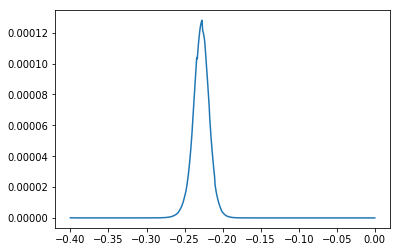

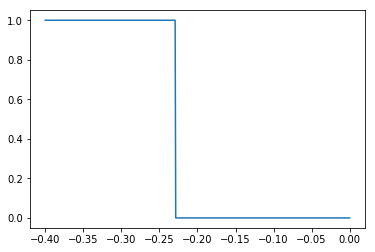

In [57]:
# sample data plots
file_index = np.random.randint(len(data_list))
V_P_vec = data_list[file_index]['V_P_vec']
current_vec = [x['current'] for x in data_list[file_index]['output']]
charge_vec = [np.sum(x['charge']) for x in data_list[file_index]['output']]

plt.figure(1)
plt.plot(V_P_vec,current_vec)

plt.figure(2)
plt.plot(V_P_vec,charge_vec)

## Loading of the data
The data is put into separate input and output lists so that it works with the code of the DNN from tensorflow.

In [104]:
inp_array = []
out_array = []
for dat in data_list:
    inp_array.append(np.cumsum(np.array([x['current'] for x in dat['output']])))
    out_array.append(np.array([np.sum(x['charge']) for x in dat['output']]))
inp_array = np.array(inp_array)
out_array = np.array(out_array)

## Constructing the DNN Regressor
A packaged DNN is used from the tensorflow.contrib.learn.DNNRegressor API.

In [114]:
model_dir_path = "/Users/sandesh/trained_networks/single_dot/"
# determines the number of inputs used as the training set
# the rest are treated as a test set
train_factor = 0.9

n_tot = inp_array.shape[0]
n_train = int(train_factor*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = inp_array[0].shape[0] 
n_out = out_array[0].shape[0] 
print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)

x_test_data = inp_array[n_train:]
y_test_data = out_array[n_train:].astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)

def get_train_inputs():
    # load a random batch of batch_size to perform the training
    batch_size = 20
    idx = np.random.randint(n_train,size=batch_size)
    
    x_train_data = inp_array[idx,:]
    y_train_data = out_array[idx,:].astype(int)
    x = tf.constant(x_train_data)
    y = tf.constant(y_train_data)
    return x,y

def get_test_inputs():
    x = tf.constant(x_test_data)
    y = tf.constant(y_test_data)
    return x,y

# load datasets
features = [tf.contrib.layers.real_valued_column("",dimension=n_inp)]
regressor = tf.contrib.learn.DNNRegressor(feature_columns=features,
                                          label_dimension=n_out,
                                          hidden_units=[1024,512,256,128,10],
                                          optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
                                         )
st = time.time()
regressor.fit(input_fn=get_train_inputs, steps=20000)

print("Completed in",time.time()-st, "seconds.")

predictions = list(regressor.predict(input_fn=get_test_inputs))
def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Accuracy : ",np.mean(accur))

Number of inputs: 512
Number of outputs: 512
Total, Training, Test
1000 900 100
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_tf_random_seed': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_session_config': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_environment': 'local', '_save_checkpoints_steps': None, '_task_id': 0, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x123a5b588>, '_model_dir': '/var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpuwf9_qtn', '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_num_worker_replicas': 0}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpuwf9_qtn/model.ckpt.
INFO:tensorflow:loss = 7.38879, step = 

INFO:tensorflow:loss = 2.23587, step = 7401 (1.515 sec)
INFO:tensorflow:global_step/sec: 42.9342
INFO:tensorflow:loss = 2.23587, step = 7501 (2.331 sec)
INFO:tensorflow:global_step/sec: 58.0909
INFO:tensorflow:loss = 2.23587, step = 7601 (1.720 sec)
INFO:tensorflow:global_step/sec: 60.3966
INFO:tensorflow:loss = 2.23587, step = 7701 (1.658 sec)
INFO:tensorflow:global_step/sec: 61.6951
INFO:tensorflow:loss = 2.23587, step = 7801 (1.619 sec)
INFO:tensorflow:global_step/sec: 68.1384
INFO:tensorflow:loss = 2.23587, step = 7901 (1.467 sec)
INFO:tensorflow:global_step/sec: 60.6321
INFO:tensorflow:loss = 2.23587, step = 8001 (1.649 sec)
INFO:tensorflow:global_step/sec: 73.6398
INFO:tensorflow:loss = 2.23587, step = 8101 (1.358 sec)
INFO:tensorflow:global_step/sec: 66.202
INFO:tensorflow:loss = 2.23587, step = 8201 (1.511 sec)
INFO:tensorflow:global_step/sec: 67.1687
INFO:tensorflow:loss = 2.23587, step = 8301 (1.488 sec)
INFO:tensorflow:global_step/sec: 60.4926
INFO:tensorflow:loss = 2.23587,

INFO:tensorflow:loss = 2.23587, step = 15801 (1.441 sec)
INFO:tensorflow:global_step/sec: 66.4205
INFO:tensorflow:loss = 2.23587, step = 15901 (1.505 sec)
INFO:tensorflow:global_step/sec: 73.9191
INFO:tensorflow:loss = 2.23587, step = 16001 (1.354 sec)
INFO:tensorflow:global_step/sec: 74.8747
INFO:tensorflow:loss = 2.23587, step = 16101 (1.335 sec)
INFO:tensorflow:global_step/sec: 73.374
INFO:tensorflow:loss = 2.23587, step = 16201 (1.362 sec)
INFO:tensorflow:global_step/sec: 76.0327
INFO:tensorflow:loss = 2.23587, step = 16301 (1.315 sec)
INFO:tensorflow:global_step/sec: 68.9096
INFO:tensorflow:loss = 2.23587, step = 16401 (1.451 sec)
INFO:tensorflow:global_step/sec: 63.84
INFO:tensorflow:loss = 2.23587, step = 16501 (1.567 sec)
INFO:tensorflow:global_step/sec: 74.0642
INFO:tensorflow:loss = 2.23587, step = 16601 (1.349 sec)
INFO:tensorflow:global_step/sec: 68.9069
INFO:tensorflow:loss = 2.23587, step = 16701 (1.451 sec)
INFO:tensorflow:global_step/sec: 59.9244
INFO:tensorflow:loss = 

## Predict using the trained DNN
The accuracy for each sample is calculated as the number of points in the voltage space where it correctly predicts the charges. The total accuracy is defined as the mean over all the samples in the test set.

In [106]:
predictions = list(regressor.predict(input_fn=get_test_inputs))
def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Accuracy : ",np.mean(accur))

INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpmmegnr7c/model.ckpt-1
Accuracy :  0.0


## Sample Predictions
A random sample from the test set is picked and the output from the DNN is compared with the actual expected output as a visualisation.

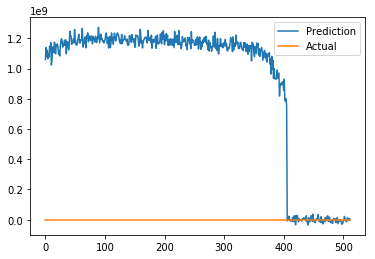

In [113]:
index = np.random.randint(n_test)
plt.plot(np.rint(predictions[index]),label="Prediction")
plt.plot(y_test_data[index],label="Actual")
plt.legend()